<a href="https://colab.research.google.com/github/Hesamalian/BERT-Embedding/blob/master/Copy_of_Pre_trained_BERT_contextualized_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -rf bert
!git clone https://github.com/google-research/bert

Cloning into 'bert'...
remote: Enumerating objects: 333, done.
remote: Total 333 (delta 0), reused 0 (delta 0), pack-reused 333
Receiving objects: 100% (333/333), 277.61 KiB | 3.75 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [0]:
import sys

sys.path.append('bert/')

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import codecs
import collections
import json
import re
import os
import pprint
import numpy as np
import tensorflow as tf

import modeling
import tokenization

In [0]:
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.122.111.130:8470


W0719 10:09:56.773096 140211060430720 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 17384077622496837368),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2600579398008595486),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6902390666166919801),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2721094601462557745),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5018244474586534085),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 5684809647906282631),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 6817311112551601495),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5202788013627376479),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14106683048301966649),
 _DeviceAttributes(/job:tpu_work

In [0]:
# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL
print('***** BERT pretrained directory: {} *****'.format(BERT_PRETRAINED_DIR))
!gsutil ls $BERT_PRETRAINED_DIR

***** BERT pretrained directory: gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12 *****
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_config.json
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.index
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.meta
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/checkpoint
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/vocab.txt


In [0]:
LAYERS = [-1,-2,-3,-4]
NUM_TPU_CORES = 8
MAX_SEQ_LENGTH = 87
BERT_CONFIG = BERT_PRETRAINED_DIR + '/bert_config.json'
CHKPT_DIR = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
VOCAB_FILE = BERT_PRETRAINED_DIR + '/vocab.txt'
INIT_CHECKPOINT = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
BATCH_SIZE = 128

In [0]:
class InputExample(object):

  def __init__(self, unique_id, text_a, text_b=None):
    self.unique_id = unique_id
    self.text_a = text_a
    self.text_b = text_b


In [0]:
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
    self.unique_id = unique_id
    self.tokens = tokens
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.input_type_ids = input_type_ids

In [0]:
def input_fn_builder(features, seq_length):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_unique_ids = []
  all_input_ids = []
  all_input_mask = []
  all_input_type_ids = []

  for feature in features:
    all_unique_ids.append(feature.unique_id)
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_input_type_ids.append(feature.input_type_ids)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "unique_ids":
            tf.constant(all_unique_ids, shape=[num_examples], dtype=tf.int32),
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_type_ids":
            tf.constant(
                all_input_type_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
    })

    d = d.batch(batch_size=batch_size, drop_remainder=False)
    return d

  return input_fn

In [0]:
def model_fn_builder(bert_config, init_checkpoint, layer_indexes, use_tpu,
                     use_one_hot_embeddings):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    unique_ids = features["unique_ids"]
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    input_type_ids = features["input_type_ids"]

    model = modeling.BertModel(
        config=bert_config,
        is_training=False,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=input_type_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)

    if mode != tf.estimator.ModeKeys.PREDICT:
      raise ValueError("Only PREDICT modes are supported: %s" % (mode))

    tvars = tf.trainable_variables()
    scaffold_fn = None
    (assignment_map,
     initialized_variable_names) = modeling.get_assignment_map_from_checkpoint(
         tvars, init_checkpoint)
    if use_tpu:

      def tpu_scaffold():
        tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
        return tf.train.Scaffold()

      scaffold_fn = tpu_scaffold
    else:
      tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

    tf.logging.info("**** Trainable Variables ****")
    for var in tvars:
      init_string = ""
      if var.name in initialized_variable_names:
        init_string = ", *INIT_FROM_CKPT*"
      tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
                      init_string)

    all_layers = model.get_all_encoder_layers()

    predictions = {
        "unique_id": unique_ids,
    }

    for (i, layer_index) in enumerate(layer_indexes):
      predictions["layer_output_%d" % i] = all_layers[layer_index]

    output_spec = tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode, predictions=predictions, scaffold_fn=scaffold_fn)
    return output_spec

  return model_fn

In [0]:
def convert_examples_to_features(examples, seq_length, tokenizer):
  """Loads a data file into a list of `InputBatch`s."""

  features = []
  for (ex_index, example) in enumerate(examples):
    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
      tokens_b = tokenizer.tokenize(example.text_b)

    if tokens_b:
      # Modifies `tokens_a` and `tokens_b` in place so that the total
      # length is less than the specified length.
      # Account for [CLS], [SEP], [SEP] with "- 3"
      _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
    else:
      # Account for [CLS] and [SEP] with "- 2"
      if len(tokens_a) > seq_length - 2:
        tokens_a = tokens_a[0:(seq_length - 2)]

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0     0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    tokens = []
    input_type_ids = []
    tokens.append("[CLS]")
    input_type_ids.append(0)
    for token in tokens_a:
      tokens.append(token)
      input_type_ids.append(0)
    tokens.append("[SEP]")
    input_type_ids.append(0)

    if tokens_b:
      for token in tokens_b:
        tokens.append(token)
        input_type_ids.append(1)
      tokens.append("[SEP]")
      input_type_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < seq_length:
      input_ids.append(0)
      input_mask.append(0)
      input_type_ids.append(0)

    assert len(input_ids) == seq_length
    assert len(input_mask) == seq_length
    assert len(input_type_ids) == seq_length

    if ex_index < 5:
      tf.logging.info("*** Example ***")
      tf.logging.info("unique_id: %s" % (example.unique_id))
      tf.logging.info("tokens: %s" % " ".join(
          [tokenization.printable_text(x) for x in tokens]))
      tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
      tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
      tf.logging.info(
          "input_type_ids: %s" % " ".join([str(x) for x in input_type_ids]))

    features.append(
        InputFeatures(
            unique_id=example.unique_id,
            tokens=tokens,
            input_ids=input_ids,
            input_mask=input_mask,
            input_type_ids=input_type_ids))
  return features

In [0]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
  """Truncates a sequence pair in place to the maximum length."""

  # This is a simple heuristic which will always truncate the longer sequence
  # one token at a time. This makes more sense than truncating an equal percent
  # of tokens from each, since if one sequence is very short then each token
  # that's truncated likely contains more information than a longer sequence.
  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_length:
      break
    if len(tokens_a) > len(tokens_b):
      tokens_a.pop()
    else:
      tokens_b.pop()

In [0]:
def read_sequence(input_sentences):
  examples = []
  unique_id = 0
  for sentence in input_sentences:
    line = tokenization.convert_to_unicode(sentence)
    examples.append(InputExample(unique_id=unique_id, text_a=line))
    unique_id += 1
  return examples
  

In [0]:
def get_features(input_text, dim=768):
#   tf.logging.set_verbosity(tf.logging.INFO)

  layer_indexes = LAYERS

  bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)

  tokenizer = tokenization.FullTokenizer(
      vocab_file=VOCAB_FILE, do_lower_case=True)

  is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2
  tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
  run_config = tf.contrib.tpu.RunConfig(
      cluster=tpu_cluster_resolver,
      tpu_config=tf.contrib.tpu.TPUConfig(
          num_shards=NUM_TPU_CORES,
          per_host_input_for_training=is_per_host))

  examples = read_sequence(input_text)

  features = convert_examples_to_features(
      examples=examples, seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)

  unique_id_to_feature = {}
  for feature in features:
    unique_id_to_feature[feature.unique_id] = feature

  model_fn = model_fn_builder(
      bert_config=bert_config,
      init_checkpoint=INIT_CHECKPOINT,
      layer_indexes=layer_indexes,
      use_tpu=True,
      use_one_hot_embeddings=True)

  # If TPU is not available, this will fall back to normal Estimator on CPU
  # or GPU.
  estimator = tf.contrib.tpu.TPUEstimator(
      use_tpu=True,
      model_fn=model_fn,
      config=run_config,
      predict_batch_size=BATCH_SIZE,
      train_batch_size=BATCH_SIZE)

  input_fn = input_fn_builder(
      features=features, seq_length=MAX_SEQ_LENGTH)

  # Get features
  for result in estimator.predict(input_fn, yield_single_examples=True):
    unique_id = int(result["unique_id"])
    feature = unique_id_to_feature[unique_id]
    output = collections.OrderedDict()
    for (i, token) in enumerate(feature.tokens):
      layers = []
      for (j, layer_index) in enumerate(layer_indexes):
        layer_output = result["layer_output_%d" % j]
        layer_output_flat = np.array([x for x in layer_output[i:(i + 1)].flat])
        layers.append(layer_output_flat)
      output[token] = sum(layers)[:dim]
  
  return output

In [0]:
embeddings = get_features(["This is a test"])


W0719 10:10:34.048337 140211060430720 deprecation_wrapper.py:119] From bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0719 10:10:36.465833 140211060430720 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f8526beaf28>) includes params argument, but params are not passed to Estimator.
W0719 10:10:36.469509 140211060430720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpzxoszqx8
W0719 10:10:36.734985 140211060430720 deprecation_wrapper.py:119] From bert/modeling.py:171: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0719 10:10:36.739857 140211060430720 deprecation_wrapper.py:119] From bert/modeling.py:409: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0719 10:10:36.971348 140211060430720 deprecation_wrapper.py:119] From bert/modeling.py:490: The name tf.assert_less_equal is deprecated. P

In [0]:
embeddings = get_features([sentences1[0]])

W0719 12:11:44.003319 140211060430720 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f8533acef28>) includes params argument, but params are not passed to Estimator.
W0719 12:11:44.005318 140211060430720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpxlshmy7p


In [0]:
sentences1[0]

'the automobile and truck industries will diversify their powertrains considerably. Besides internal combustion engine (ICE) vehicles, popular automobiles will more than likely include plug-in hybrid electric vehicles (PHEVs), fully battery-powered electric vehicles (BEVs), and fuel cell electric vehicles (FCEVs) running on hydrogen. It’s still not clear precisely which vehicles customers will prefer; nevertheless, auto makers need to make strategic decisions today regarding their fuels and powertrains.'

In [0]:
sentences1=['the automobile and truck industries will diversify their powertrains considerably. Besides internal combustion engine (ICE) vehicles, popular automobiles will more than likely include plug-in hybrid electric vehicles (PHEVs), fully battery-powered electric vehicles (BEVs), and fuel cell electric vehicles (FCEVs) running on hydrogen. It’s still not clear precisely which vehicles customers will prefer; nevertheless, auto makers need to make strategic decisions today regarding their fuels and powertrains.','This report provides a detailed analysis that compares the total cost of ownership (TCO) for each type of fuel and powertrain — today and projected through 2030. The estimates are based on factors such as required infrastructure, cost of fuel, taxes, regulations, mileage requirements, efficiency improvements, depreciation, maintenance, and insurance. Knowing the total cost of ownership can help auto makers generate a strategic road map during this period of disruption.','Although TCO will rise for the ICE, it will remain the most cost-effective vehicle for many drivers. However, technological advances in batteries, and other factors, will make BEVs increasingly competitive. FCEVs will also drop in cost. To be strategically ready for change, auto makers and suppliers should consider four broad actions today: prepare to ramp up production for the vehicles they choose to produce; optimize product costs across powertrains; focus on innovation (including more collaborative innovation); and recruit and train engineers familiar with the new powertrain alternatives.','It’s not necessary to consult a crystal ball to realize that, by the end of the next decade, the variety of automobiles on the road won’t resemble today’s relatively homogenous fleet at all. Today’s internal combustion engine (ICE) vehicles will be complemented by a mixture of powertrains, all legitimate suitors for customer attention. Besides','ICE vehicles, there will more than likely be plug-in hybrid electric vehicles (PHEVs), fully battery-powered electric vehicles (BEVs), and fuel cell electric vehicles (FCEVs) running on hydrogen.','categories, where BEVs are the best TCO option. This is primarily because for a low-range vehicle, the significant savings in fuel costs from BEVs compensate for the higher cost of battery powertrains.','However, for longer-range vehicles, ICE comes out on top. The price of an ICE powertrain for a given car does not increase with greater range (except perhaps for the minimal expense of a larger gas tank), whereas battery prices for electric vehicles (EVs) do rise as the range (and, hence, the size of the batteries) expands.','Between 2018 and 2030, cost differences among powertrains will change considerably, thus altering the TCO analyses. For each type of vehicle, here is how we anticipate that TCOs will be affected by these cost shifts:','To bring some clarity and direction to this challenge, Strategy&amp;, PwC’s strategy consulting business, recently undertook a detailed analysis that compares the total cost of ownership (TCO) for each powertrain currently and at landmark years through 2030. We projected the cost and required infrastructure to produce and distribute alternative fuels.','We plugged these factors into TCO analyses covering three separate automotive segments — budget, volume, and premium — and four different mileage ranges that a car can travel before refueling. In our estimates for 2030, we also included the impact of technological gains (mainly for batteries and power electronics), more stringent regulatory requirements for combustion engines, efficiency improvements, fuel costs, and depreciation. Taxes, maintenance, and insurance were also considered but were weighted less heavily.']


In [0]:
results = [get_features([a]) for a in sentences1]

W0719 12:13:02.248336 140211060430720 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f8522ae3d90>) includes params argument, but params are not passed to Estimator.
W0719 12:13:02.250980 140211060430720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpf2u1lyfj
W0719 12:13:29.853945 140211060430720 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f8533357488>) includes params argument, but params are not passed to Estimator.
W0719 12:13:29.855920 140211060430720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpq37x_tnn
W0719 12:14:00.266627 140211060430720 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f8523ea71e0>) includes params argument, but params are not passed to Estimator.
W0719 12:14:00.268734 140211060430720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmp6wm_9bxo
W0719 12:14:30.9781

In [0]:
def sent_vectorizer(model):
    sent_vec =[]
    numw = 0
    for key,value in model.items():
        try:
            if numw == 0:
                sent_vec = model[key]
            else:
                sent_vec = np.add(sent_vec, model[key])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw
  
  
X=[]
for res in results:
    X.append(sent_vectorizer(res))

In [0]:
from gensim.models import Word2Vec
  
from nltk.cluster import KMeansClusterer
from nltk import word_tokenize
import nltk
import numpy as np 
  
from sklearn import cluster
from sklearn import metrics

[0, 1, 0, 0, 2, 2, 2, 0, 1, 1]
0 the automobile and truck industries will diversify their powertrains considerably. Besides internal combustion engine (ICE) vehicles, popular automobiles will more than likely include plug-in hybrid electric vehicles (PHEVs), fully battery-powered electric vehicles (BEVs), and fuel cell electric vehicles (FCEVs) running on hydrogen. It’s still not clear precisely which vehicles customers will prefer; nevertheless, auto makers need to make strategic decisions today regarding their fuels and powertrains.
1 This report provides a detailed analysis that compares the total cost of ownership (TCO) for each type of fuel and powertrain — today and projected through 2030. The estimates are based on factors such as required infrastructure, cost of fuel, taxes, regulations, mileage requirements, efficiency improvements, depreciation, maintenance, and insurance. Knowing the total cost of ownership can help auto makers generate a strategic road map during this perio

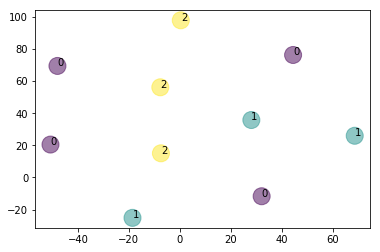

In [0]:

NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)
  
  
  
# for index, sentence in enumerate(sentences):    
#     print (str(assigned_clusters[index]) + ":" + str(sentence))
 
     
     
     
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
# print ("Cluster id labels for inputted data")
# print (labels)
# print ("Centroids data")
# print (centroids)
  
# print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
# print (kmeans.score(X))
  
# silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
# print ("Silhouette_score: ")
# print (silhouette_score)
 
 
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
 
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(X)
 
 
plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
 
 
for j in range(len(sentences1)):    
   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   print ("%s %s" % (assigned_clusters[j],  sentences1[j]))